# GNAV pipeline application on VTTI dataset

With a satellite reference image, we intend to utilize a SfM solution to match ground segments of images to the reference map.
- Inputs: Reference image (satellite), SfM solution (images, points, cameras), selected images (5)
- Output: Correction solutions for translation, rotation, scaling

APPLYING ORIGINAL PIPELINE ON VTTI AIRPORT

In [1]:
import numpy as np
import cv2
import open3d as o3d
import plotly.graph_objects as go
import plotly.io as pio
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree
import imageio
# %matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.path import Path
import time

from groundNAV_agent import *
from colmapParsingUtils import *
import pycolmap

# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# UPLOAD INPUTS

# CLOSER IMAGES 
# Load in necessary parameters for gNAV agent 
# Define Class Parameters 

images_colm  = "VTTI_data/images.txt"
cameras_colm = "VTTI_data/cameras.txt"
pts3d_colm = "VTTI_data/points3D.txt"

# Images selected for local corrections
image_1 = "/home/daniel-choate/Datasets/COLMAP/VTTI_airport/Images/frame_30850.jpg"
image_2 = "/home/daniel-choate/Datasets/COLMAP/VTTI_airport/Images/frame_30900.jpg"
image_3 = "/home/daniel-choate/Datasets/COLMAP/VTTI_airport/Images/frame_30950.jpg"
image_4 = "/home/daniel-choate/Datasets/COLMAP/VTTI_airport/Images/frame_31000.jpg"
image_5 = "/home/daniel-choate/Datasets/COLMAP/VTTI_airport/Images/frame_31050.jpg"
image_6 = "/home/daniel-choate/Datasets/COLMAP/VTTI_airport/Images/frame_31100.jpg"
image_7 = "/home/daniel-choate/Datasets/COLMAP/VTTI_airport/Images/frame_31150.jpg"
image_8 = "/home/daniel-choate/Datasets/COLMAP/VTTI_airport/Images/frame_31200.jpg"

# Load in satellite reference image
sat_ref = "VTTI_data/Satellite_schematic.png"
# sat_ref = cv2.imread('TTurf/TurfSat.jpg')

# Organize for agent params
images = [image_1, image_2, image_3, image_4, image_5, image_6, image_7, image_8]

In [3]:
# Create class
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, images, sat_ref)

# Grab raw points and RGB data for scene and reference cloud
scene_pts, rgb_data = gnav.grab_pts(gnav.pts3d_c)
ref_pts, ref_rgb = gnav.ref_pts, gnav.ref_rgb

In [4]:
# Plot the initial scene
# PLOT INITIAL POINT CLOUD AND POSES 
# Create Open3D visualizer object
vis = o3d.visualization.Visualizer()
vis.create_window(window_name='3D Plot with Pose Axes and Point Cloud')

# Add coordinate axes
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=500)

# # loop through poses 
# # for pose in poses:
# for i in range(len(poses)):
#     if (poses[i] == 0).all():
#         print("Empty pose", i)
#         continue
# # for i in range(1):
#     # print(i)
#     homog_t = poses[i]
#     # homog_t = pose
#     # print(homog_t)
#     s = i*.01
#     # print(s)
#     # if i in np.arange(106,135):
#     if i in np.array([35, 40, 45, 50, 55, 60, 65, 70]):
#         axes1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.25).transform(homog_t)
#         vis.add_geometry(axes1)
#     axes1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.1).transform(homog_t)
#     # axes1 = copy.deepcopy(axes).transform(homog_t)
#     vis.add_geometry(axes1)
    
scene_cloud = o3d.geometry.PointCloud()
scene_cloud.points = o3d.utility.Vector3dVector(scene_pts)
scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)


ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(ref_rgb)

vis.add_geometry(axes)
# vis.add_geometry(scene_cloud)
vis.add_geometry(ref_cloud)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 1.5


# Run the visualizer
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 74
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 74
pci id for fd 74: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


### Changing REF FRAME TO MIDDLE

In [5]:
# Ground plane point indices (retrieved through pos file)
pts_gnd_idx = np.array([525, 532, 533, 534, 538, 539, 6178, 6180, 6188, 6190, 6193, 6192, 5385, 5386, 5388, 5389, 5390, 5391, 5392, 5393])

# MADE IT UP TO HERE ******************
# tform_ref_frame = gnav.set_ref_frame(pts_gnd_idx) # THIS IS WHAT I AM CHANGING 
tform_ref_frame = gnav.set_ref_frame_mid(pts_gnd_idx) # NEW VERSION
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("\nReference frame transformation\n", tform_ref_frame_pts)

Gravity vector 
 [-0.00113406  0.99989814 -0.01422744]

Height h_0 =  0.15607730091415392
Focal length 
 2213.124120400344

Reference frame transformation
 [[-7.64602454e-01  8.30259685e-03  6.44448721e-01  3.11603150e+00]
 [ 6.44501204e-01  1.16091750e-02  7.64515157e-01  2.89949680e+00]
 [-1.13405686e-03  9.99898142e-01 -1.42274374e-02 -1.60359011e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [6]:
# Transform all points to the new coordinate system 
# Not necessary since we aren't using the cloud, but a good visual check for coord frame
tform_ref_frame_inv = gnav.inv_homog_transform(tform_ref_frame)
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(scene_pts, gnav.origin_w, tform_ref_frame_inv)
# print(origin_ref)
# Transform scene cloud to 2D (also as a visual check)
# Note: 2d projection will look off with z=-1; see TTurf_v2 for cropping method
scene_ref_2d = gnav.proj_2d_scene(scene_pts_ref)
# print(scene_ref_2d)

/home/daniel-choate/ASAR/s3/groundNAV_agent.py:365: RuntimeWarning: divide by zero encountered in divide
  pts_2D = pts / pts[:, 2][:, np.newaxis]
/home/daniel-choate/ASAR/s3/groundNAV_agent.py:365: RuntimeWarning: invalid value encountered in divide
  pts_2D = pts / pts[:, 2][:, np.newaxis]


In [7]:
# Plot the initial scene
# PLOT INITIAL POINT CLOUD AND POSES 
# Create Open3D visualizer object
vis = o3d.visualization.Visualizer()
vis.create_window(window_name='3D Plot with Pose Axes and Point Cloud')

# Add coordinate axes
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
    
scene_cloud = o3d.geometry.PointCloud()
scene_cloud.points = o3d.utility.Vector3dVector(scene_pts_ref)
scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)


ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(ref_rgb)

vis.add_geometry(axes)
vis.add_geometry(scene_cloud)
# vis.add_geometry(ref_cloud)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 1.5


# Run the visualizer
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 74
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 74
pci id for fd 74: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


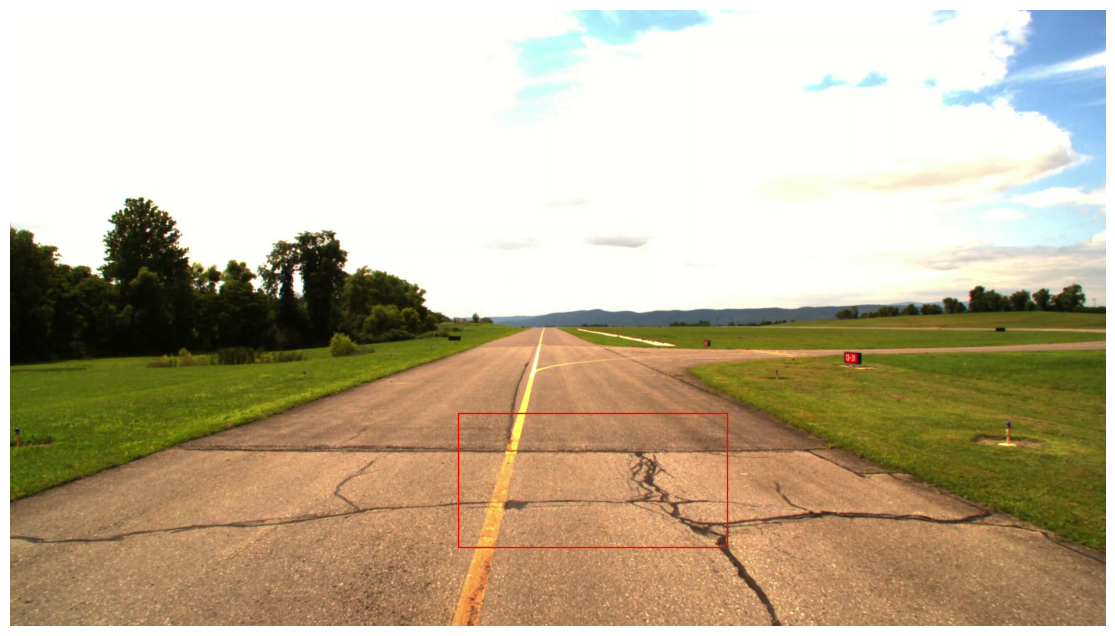

In [8]:
# Image 0 
imnum = 0
x,y = 1000,900
side_x = 600 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

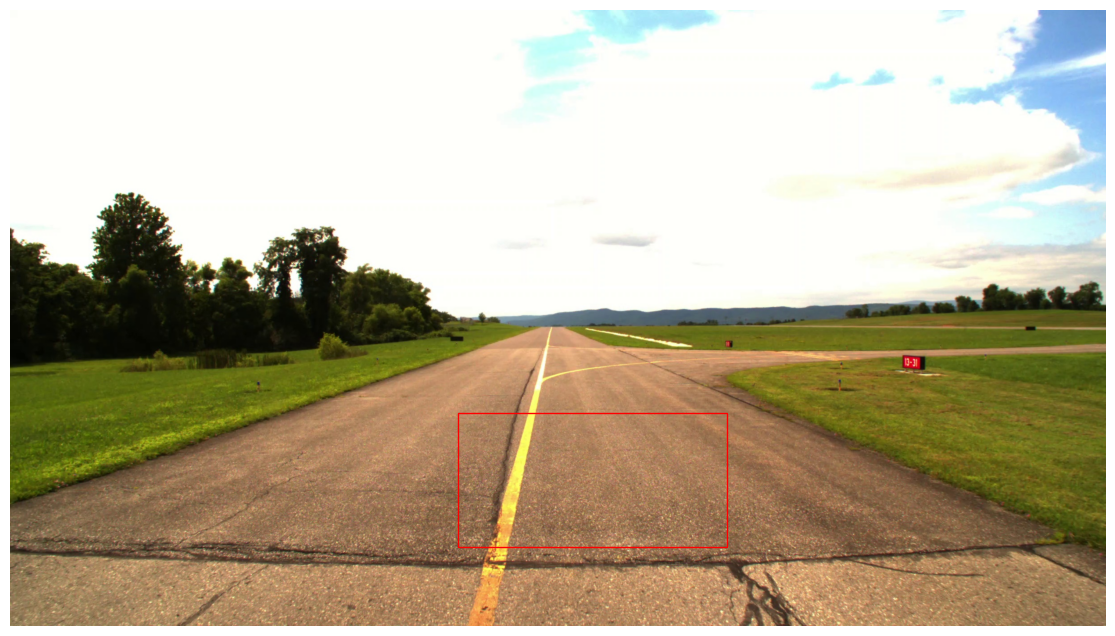

In [9]:
# Image 1 
imnum = 1
x,y = 1000,900
side_x = 600 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

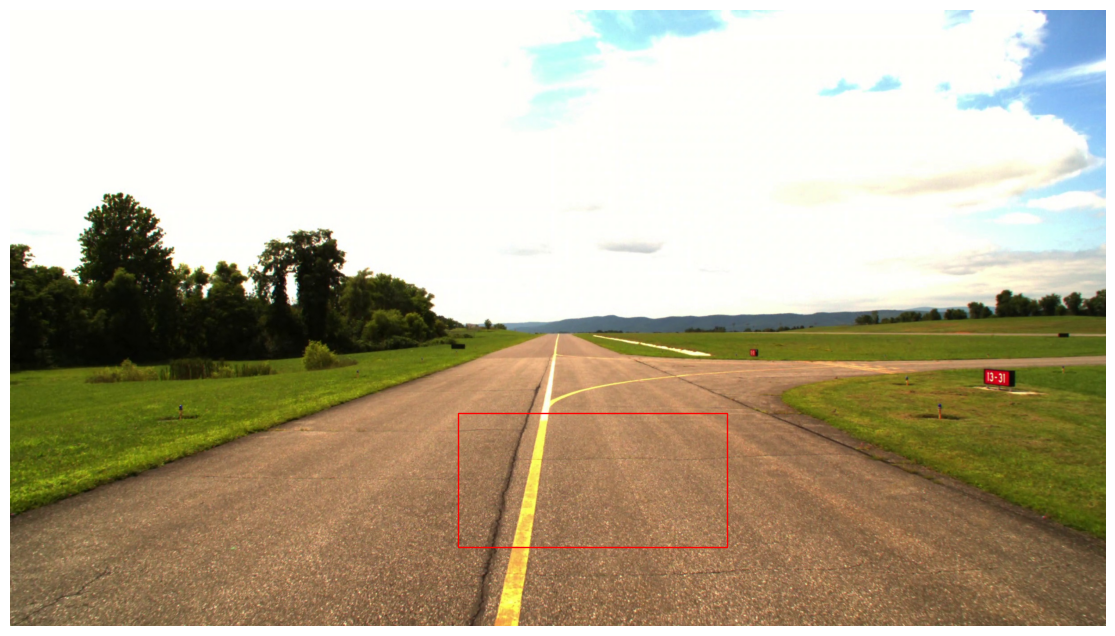

In [10]:
# Image 2
imnum = 2
x,y = 1000,900
side_x = 600 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

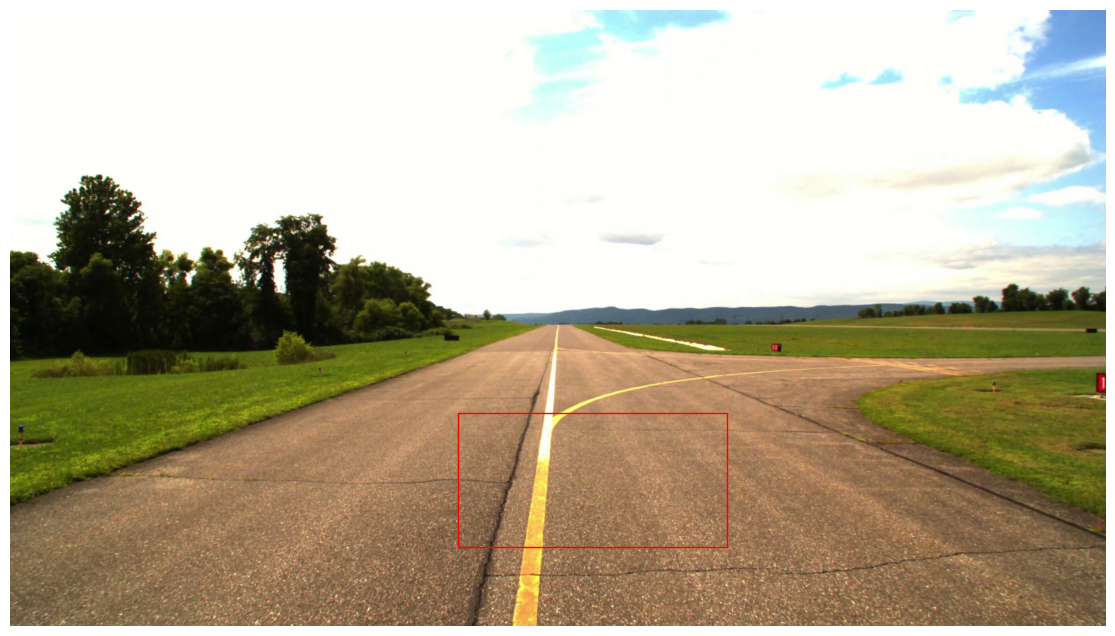

In [11]:
# Image 3
imnum = 3
x,y = 1000,900
side_x = 600 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

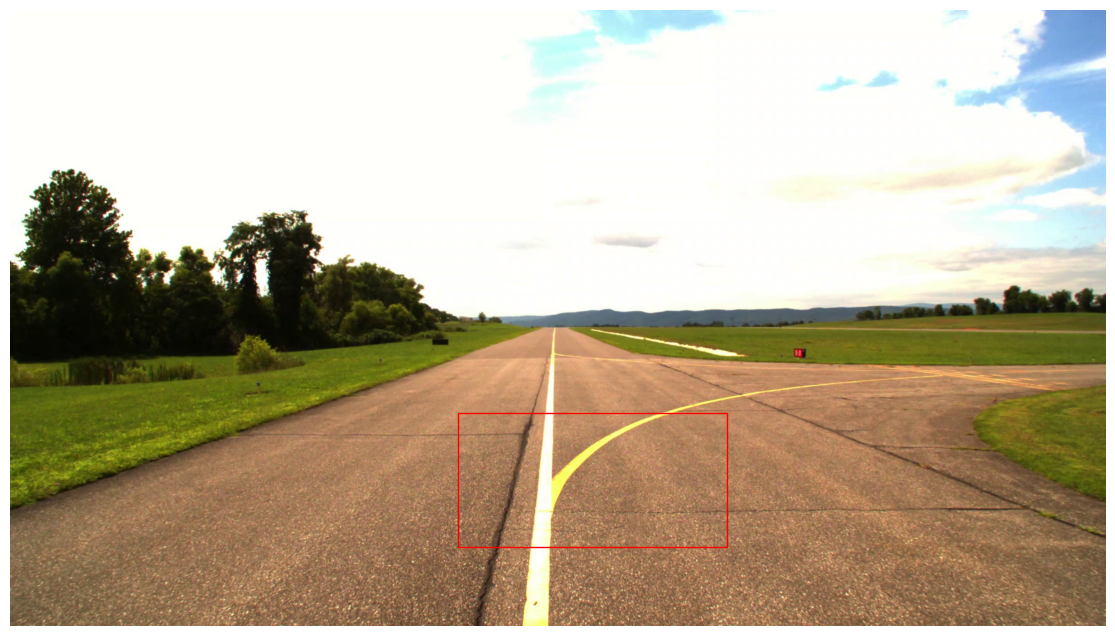

In [12]:
# Image 4
imnum = 4
x,y = 1000,900
side_x = 600 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

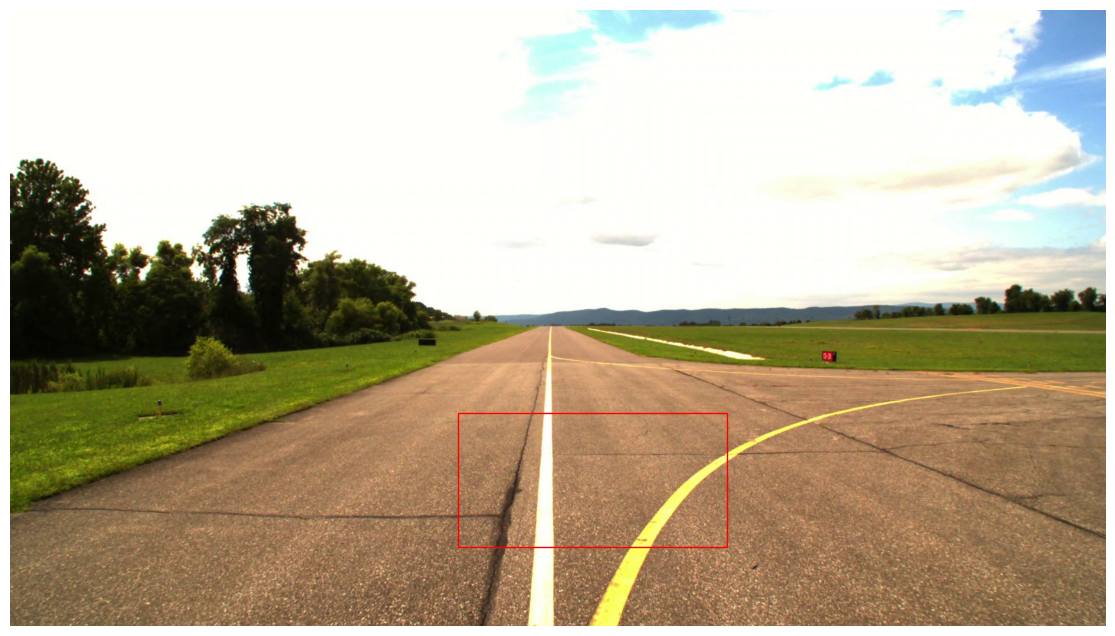

In [13]:
# Image 5
imnum = 5
x,y = 1000,900
side_x = 600 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

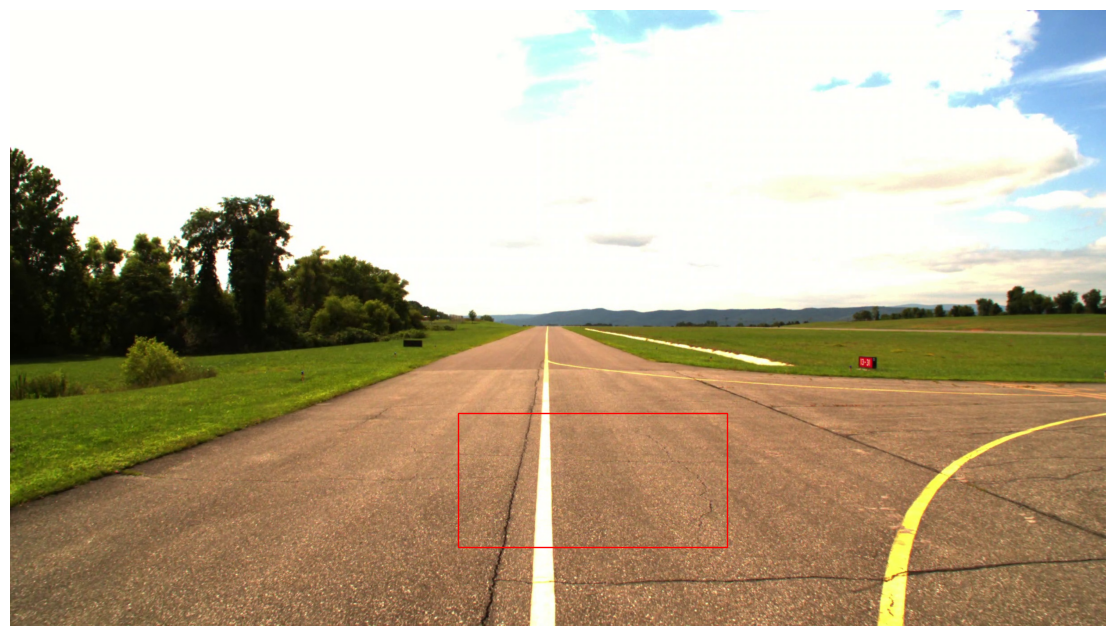

In [14]:
# Image 6
imnum = 6
x,y = 1000,900
side_x = 600 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

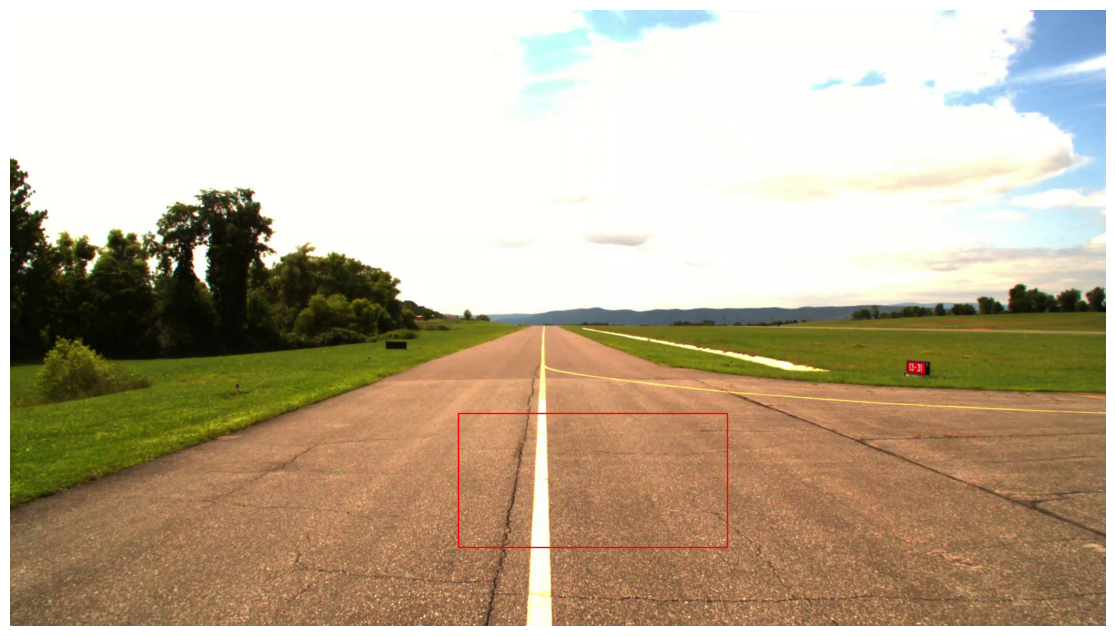

In [15]:
# Image 7
imnum = 7
x,y = 1000,900
side_x = 600 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

In [16]:
## Generate projection of image sections 
for i in range(len(images)):
# Just for the first image for now
# for i in range(1):
    # Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # Get transformation matrix that move from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4

Done image  5

Done image  6

Done image  7


In [17]:
# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene with satellite reference")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# If we just want to look at specific images
specified_clouds = np.array([0,1,2,3,4,5,6,7])

for i in specified_clouds:
    print(i)
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['pts'])
    cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
    vis.add_geometry(cloud)
    

# # Create point cloud for image points
# im0_cloud = o3d.geometry.PointCloud()
# im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['pts'])
# im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# Create point cloud for reference cloud (satellite)
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

# Add necessary geometries to visualization 
vis.add_geometry(axis_origin)
# vis.add_geometry(ref_cloud)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # # Set up initial viewpoint
# # view_control = vis.get_view_control()
# # # Direction which the camera is looking
# # view_control.set_front([0, 0, -1])  # Set the camera facing direction
# # # Point which the camera revolves about 
# # view_control.set_lookat([0, 0, 0])   # Set the focus point
# # # Defines which way is up in the camera perspective 
# # view_control.set_up([0, -1, 0])       # Set the up direction
# # view_control.set_zoom(.45)           # Adjust zoom if necessary

# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
pci id for fd 82: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


0
1
2
3
4
5
6
7


In [18]:
# Implementing an initial guess for the local image 

# SCALE for initial guess 
# scale = gnav.focal/39
scale = 30

# Avg guess for OLD IMAGES  
x = -150
y = -205
yaw = np.deg2rad(165)


tform_guess = gnav.tform_create(x,y,0,0,0,yaw)
gnav.best_guess_tform = tform_guess
gnav.best_guess_scale = scale
# gnav.best_guess_scale_MD = s_mat # Multi-directional (MD)
# print(tform_guess)


# NEW IMPLEMENTATION STRATEGY
for i in range(len(images)):
# Just for the first image for now
# for i in range(1):
    loc_im_pts = gnav.im_mosaic[i]['pts'].copy()
    # print(loc_im_pts)

    loc_im_pts[:, :2] *= scale # For SINGLE scale factor
    # loc_im_pts = loc_im_pts @ s_mat # For MULTI-DIRECTIONAL scale factor
    # Get new points 
    __, loc_im_pts_guess, loc_im_vec_guess = gnav.unit_vec_tform(loc_im_pts, gnav.origin_w, tform_guess)
    gnav.im_pts_best_guess[i] = {'pts': loc_im_pts_guess}
    # gnav.im_pts_best_guess[i]['tree'] = cKDTree(loc_im_pts_guess) # UNECESSARY 

    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4

Done image  5

Done image  6

Done image  7


In [19]:
# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene with satellite reference")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100)

# If we just want to look at specific images
specified_clouds = np.array([0,1,2,3,4,5,6,7])

for i in specified_clouds:
    print(i)
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[i]['pts'])
    cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
    vis.add_geometry(cloud)
    

# # Create point cloud for image points
# im0_cloud = o3d.geometry.PointCloud()
# im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['pts'])
# im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# Create point cloud for reference cloud (satellite)
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

# Add necessary geometries to visualization 
vis.add_geometry(axis_origin)
vis.add_geometry(ref_cloud)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # # Set up initial viewpoint
# # view_control = vis.get_view_control()
# # # Direction which the camera is looking
# # view_control.set_front([0, 0, -1])  # Set the camera facing direction
# # # Point which the camera revolves about 
# # view_control.set_lookat([0, 0, 0])   # Set the focus point
# # # Defines which way is up in the camera perspective 
# # view_control.set_up([0, -1, 0])       # Set the up direction
# # view_control.set_zoom(.45)           # Adjust zoom if necessary

# Run and destroy visualization 
vis.run()
vis.destroy_window()

0
1


libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
pci id for fd 82: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


2
3
4
5
6
7
